# DeepShot: Player Embedding Model

In this notebook, we'll build a player embedding model to capture player-specific shooting patterns.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
models_dir = Path('../models')
player_embedding_dir = models_dir / 'player_embedding'

for directory in [processed_dir, features_dir, models_dir, player_embedding_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.15.0
GPU available: []


## Data Preparation

In [16]:
# Load shot data with features
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
print(f"Loaded {len(shots)} shots")

# Create player dictionary
player_encoder = LabelEncoder()
player_ids = player_encoder.fit_transform(shots['player_name'].unique())
player_names = shots['player_name'].unique()
player_dict = dict(zip(player_names, player_ids))
id_to_player_dict = dict(zip(player_ids, player_names))

print(f"Created player dictionary with {len(player_dict)} players")

# Add player IDs to shot features
shots['player_id'] = shots['player_name'].map(player_dict)
shots['player_id'] = shots['player_id'].astype(int)

# Save player dictionary for later use
player_dict_df = pd.DataFrame({
    'player_name': player_names,
    'player_id': player_ids
})
player_dict_df.to_csv(processed_dir / 'player_dict.csv', index=False)

Loaded 4650091 shots
Created player dictionary with 2164 players


In [17]:
# Select relevant features for the embedding model
embedding_features = ['player_id', 'loc_x', 'loc_y', 'shot_distance', 'shot_angle', 'shot_made']
embedding_data = shots[embedding_features].copy()

# Drop rows with missing values
embedding_data = embedding_data.dropna()

# Define features and target
X = embedding_data.drop('shot_made', axis=1)
y = embedding_data['shot_made']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 2976057 samples
Validation set: 744015 samples
Testing set: 930019 samples


## Exploring Player Shot Patterns

In [18]:
# Calculate shot success rate by player
player_shot_stats = shots.groupby('player_name').agg(
    total_shots=('shot_made', 'count'),
    made_shots=('shot_made', 'sum'),
    success_rate=('shot_made', 'mean')
).reset_index()

# Sort by total shots
player_shot_stats = player_shot_stats.sort_values('total_shots', ascending=False)

# Display top players by total shots
player_shot_stats.head(10)

,player_name,total_shots,made_shots,success_rate
1304,LEBRON JAMES,29311,14837,0.506192
283,CARMELO ANTHONY,24144,10803,0.447440
1789,RUSSELL WESTBROOK,21648,9486,0.438193
1214,KEVIN DURANT,20737,10433,0.503110
894,JAMES HARDEN,19039,8392,0.440779
617,DWYANE WADE,18297,8753,0.478384
571,DIRK NOWITZKI,18285,8637,0.472354
503,DEMAR DEROZAN,18006,8440,0.468733
1248,KOBE BRYANT,17869,7916,0.443002
2079,VINCE CARTER,17584,7568,0.430391


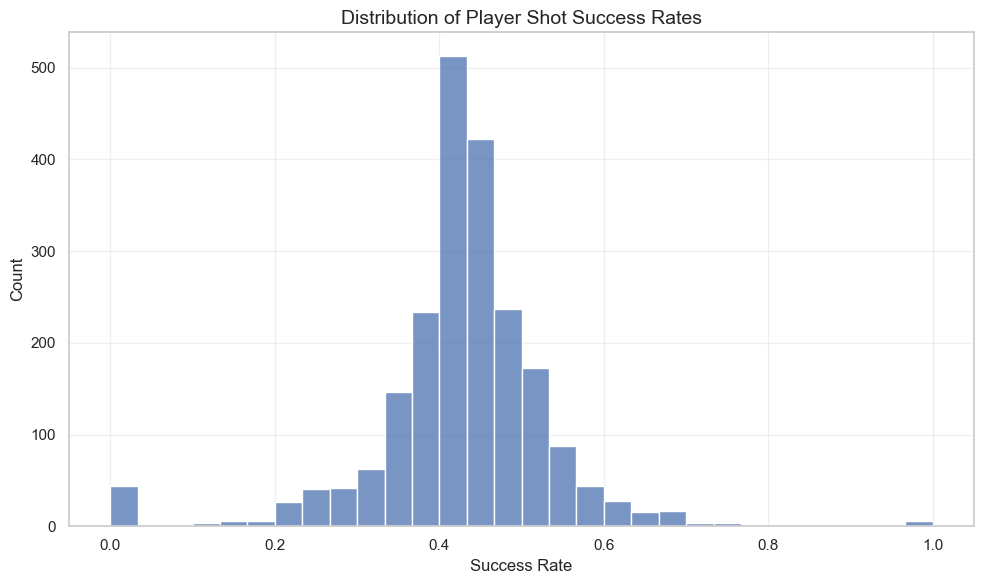

In [19]:
# Plot distribution of success rates
plt.figure(figsize=(10, 6))
sns.histplot(player_shot_stats['success_rate'], bins=30)
plt.title('Distribution of Player Shot Success Rates', fontsize=14)
plt.xlabel('Success Rate')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_62731/619678604.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  player_distance_dist = shots.groupby(['player_name', 'distance_bin']).size().unstack(fill_value=0)


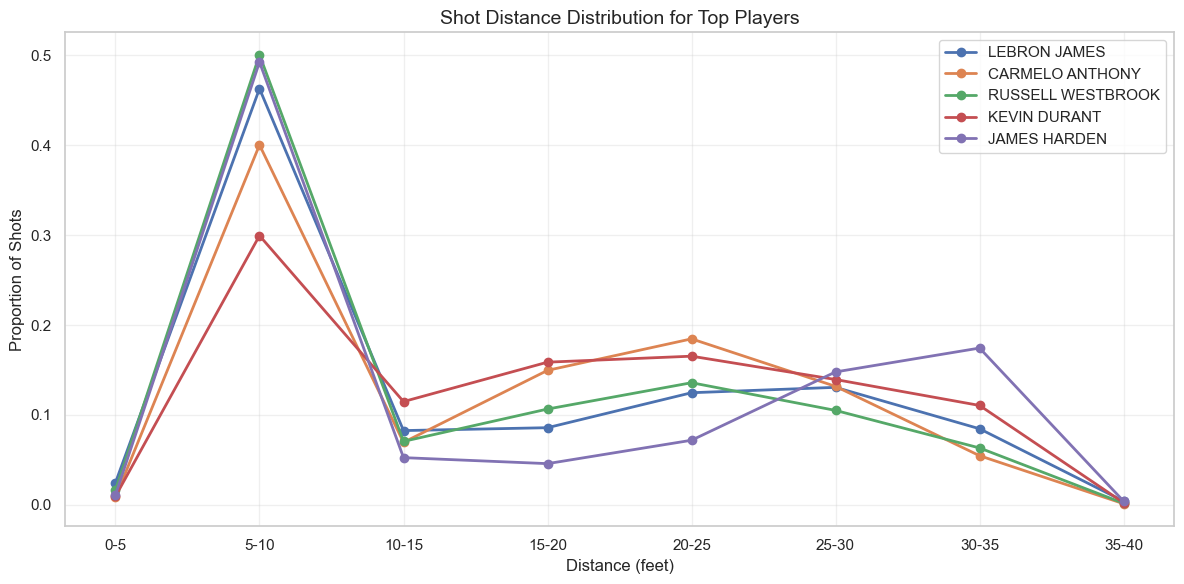

In [20]:
# Create distance bins
distance_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
distance_labels = [f"{distance_bins[i]}-{distance_bins[i+1]}" for i in range(len(distance_bins)-1)]

# Add distance bin column
shots['distance_bin'] = pd.cut(shots['shot_distance'], bins=distance_bins, labels=distance_labels)

# Calculate shot distribution by player and distance bin
player_distance_dist = shots.groupby(['player_name', 'distance_bin']).size().unstack(fill_value=0)

# Normalize by player
player_distance_dist = player_distance_dist.div(player_distance_dist.sum(axis=1), axis=0)

# Plot distance distributions for top players
top_players = player_shot_stats.head(5)['player_name'].tolist()

plt.figure(figsize=(12, 6))
for player in top_players:
    if player in player_distance_dist.index:
        plt.plot(player_distance_dist.columns, player_distance_dist.loc[player], marker='o', linewidth=2, label=player)

plt.title('Shot Distance Distribution for Top Players', fontsize=14)
plt.xlabel('Distance (feet)')
plt.ylabel('Proportion of Shots')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Building the Embedding Model

In [21]:
# Separate player IDs and other features
X_train_player_ids = X_train['player_id'].values.astype(int)
X_train_features = X_train.drop('player_id', axis=1).values

X_val_player_ids = X_val['player_id'].values.astype(int)
X_val_features = X_val.drop('player_id', axis=1).values

X_test_player_ids = X_test['player_id'].values.astype(int)
X_test_features = X_test.drop('player_id', axis=1).values

print(f"Player ID arrays shape: {X_train_player_ids.shape}, {X_val_player_ids.shape}, {X_test_player_ids.shape}")
print(f"Feature arrays shape: {X_train_features.shape}, {X_val_features.shape}, {X_test_features.shape}")

Player ID arrays shape: (2976057,), (744015,), (930019,)
Feature arrays shape: (2976057, 4), (744015, 4), (930019, 4)


In [22]:
# Define embedding dimension
embedding_dim = 32  # Adjust based on the number of players and complexity of patterns
num_players = len(player_dict)

# Define model parameters
hidden_units = [128, 64]  # Hidden layer sizes
dropout_rate = 0.3  # Dropout rate for regularization
l2_reg = 0.001  # L2 regularization strength

# Define input layers
player_input = keras.Input(shape=(1,), name='player_input')
features_input = keras.Input(shape=(X_train_features.shape[1],), name='features_input')

# Player embedding layer
player_embedding = layers.Embedding(
    input_dim=num_players,
    output_dim=embedding_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=keras.regularizers.l2(l2_reg),
    name='player_embedding'
)(player_input)
player_embedding = layers.Flatten()(player_embedding)

# Combine player embedding with other features
combined = layers.Concatenate()([player_embedding, features_input])

# Hidden layers
x = combined
for i, units in enumerate(hidden_units):
    x = layers.Dense(
        units=units,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg),
        name=f'hidden_{i+1}'
    )(x)
    x = layers.Dropout(dropout_rate)(x)

# Output layer
output = layers.Dense(
    units=1,
    activation='sigmoid',
    name='output'
)(x)

# Create model
model = keras.Model(inputs=[player_input, features_input], outputs=output)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 player_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 player_embedding (Embeddin  (None, 1, 32)                69248     ['player_input[0][0]']        
 g)                                                                                               
                                                                                                  
 flatten_1 (Flatten)         (None, 32)                   0         ['player_embedding[0][0]']    
                                                                                                  
 features_input (InputLayer  [(None, 4)]                  0         []                      

## Training the Model

In [23]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=str(player_embedding_dir / 'player_embedding_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train model
history = model.fit(
    [X_train_player_ids, X_train_features], y_train,
    epochs=30,  # Reduced for faster training
    batch_size=128,
    validation_data=([X_val_player_ids, X_val_features], y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/30
23236/23251 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.6046
Epoch 1: val_loss improved from inf to 0.66666, saving model to ../models/player_embedding/player_embedding_best.keras
23251/23251 [==============================] - 88s 4ms/step - loss: 0.6761 - accuracy: 0.6046 - val_loss: 0.6667 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 2/30
23249/23251 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.6096
Epoch 2: val_loss improved from 0.66666 to 0.66574, saving model to ../models/player_embedding/player_embedding_best.keras
23251/23251 [==============================] - 85s 4ms/step - loss: 0.6681 - accuracy: 0.6096 - val_loss: 0.6657 - val_accuracy: 0.6129 - lr: 0.0010
Epoch 3/30
23245/23251 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6098
Epoch 3: val_loss did not improve from 0.66574
23251/23251 [==============================] - 89s 4ms/step - loss: 0.6678 - accuracy: 0.6098 - val_loss: 0.6658 

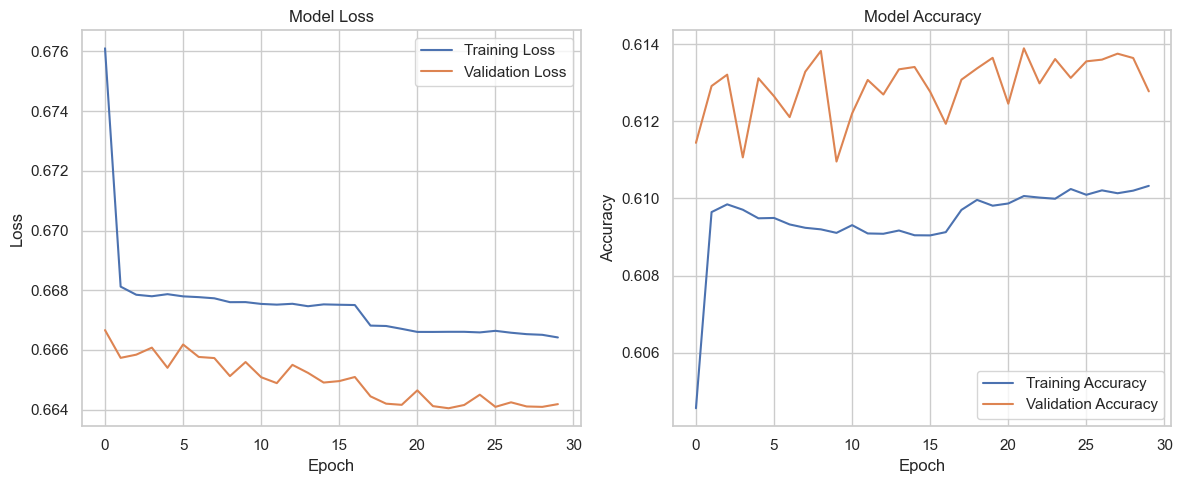

In [24]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluating the Model

29064/29064 [==============================] - 30s 1ms/step - loss: 0.6646 - accuracy: 0.6119
Test Loss: 0.6646
Test Accuracy: 0.6119
29064/29064 [==============================] - 27s 913us/step

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.80      0.69    505457
        True       0.62      0.39      0.48    424562

    accuracy                           0.61    930019
   macro avg       0.61      0.59      0.58    930019
weighted avg       0.61      0.61      0.59    930019



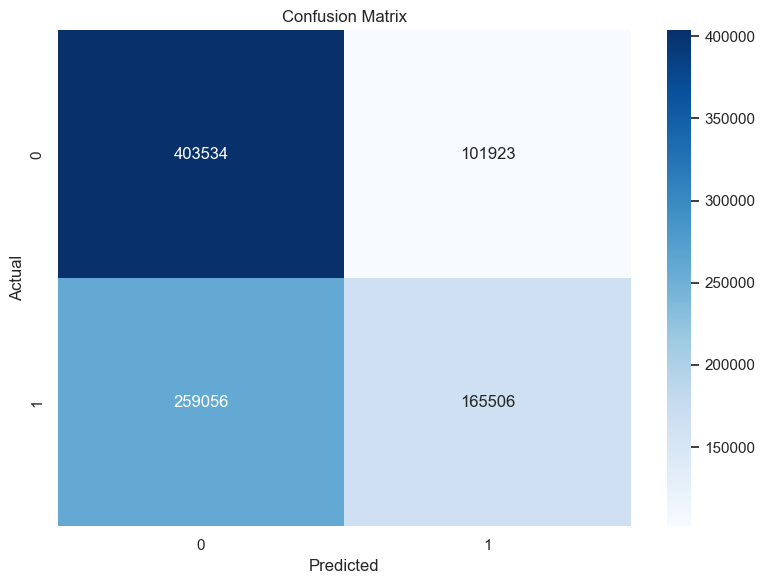

In [25]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate([X_test_player_ids, X_test_features], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict([X_test_player_ids, X_test_features])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Extracting Player Embeddings

In [26]:
# Extract player embeddings
embedding_layer = model.get_layer('player_embedding')
player_embeddings = embedding_layer.get_weights()[0]

print(f"Player embeddings shape: {player_embeddings.shape}")

# Create DataFrame with player embeddings
embedding_df = pd.DataFrame(player_embeddings)
embedding_df['player_id'] = range(len(player_embeddings))
embedding_df['player_name'] = embedding_df['player_id'].map(id_to_player_dict)

# Display sample of player embeddings
embedding_df.head()

Player embeddings shape: (2164, 32)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,player_id,player_name
0,9.837602e-16,-2.802440e-14,8.347377e-19,-3.577595e-18,3.063971e-15,4.446721e-15,1.690688e-14,1.555431e-16,8.359300e-13,1.825738e-14,...,4.353356e-15,-7.506702e-15,7.803376e-16,-2.868006e-14,-1.073146e-13,-1.120218e-13,4.917154e-15,6.423791e-14,0,A.J. LAWSON
1,-1.505853e-09,-1.291292e-10,7.609399e-13,1.577662e-11,7.603813e-11,-4.410682e-11,-1.250930e-07,-1.422818e-12,5.775021e-07,3.633760e-08,...,5.872852e-11,4.299699e-10,1.919852e-11,-4.776404e-10,1.237773e-06,3.694926e-09,-3.592142e-08,-8.127141e-09,1,AARON BROOKS
2,1.769097e-07,-1.736433e-08,4.195782e-10,-7.181247e-10,-2.179660e-10,6.399464e-09,1.311709e-06,-1.595920e-10,3.157507e-05,-1.930276e-06,...,-6.214785e-09,-9.249338e-09,-1.084658e-09,-3.989845e-08,-7.176166e-05,1.855301e-07,6.369833e-06,1.440670e-07,2,AARON GORDON
3,1.674825e-09,-8.945805e-11,-1.332219e-12,-1.190828e-12,1.868319e-11,6.005248e-12,-2.059073e-08,-5.365144e-13,1.490589e-07,-6.461283e-09,...,3.732792e-12,6.336553e-12,2.531841e-12,7.573542e-10,3.673675e-08,-1.884760e-09,8.288108e-10,-2.102039e-09,3,AARON GRAY
4,-5.533948e-32,-8.769870e-33,-1.577605e-32,4.771758e-32,-2.713737e-32,-4.545392e-32,4.519308e-32,5.291079e-32,4.607077e-32,4.365961e-32,...,-4.965293e-32,3.216235e-32,-4.068652e-32,2.894681e-32,-1.544275e-32,-3.843590e-32,-5.537285e-32,-1.086562e-32,4,AARON HARRISON


In [27]:
# Save player embeddings
embedding_df.to_csv(player_embedding_dir / 'player_embeddings.csv', index=False)
print(f"Saved player embeddings to {player_embedding_dir / 'player_embeddings.csv'}")

Saved player embeddings to ../models/player_embedding/player_embeddings.csv


## Visualizing Player Embeddings

In [28]:
# Reduce dimensionality for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for initial dimensionality reduction
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(player_embeddings)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Create DataFrame for visualization
viz_df = pd.DataFrame({
    'x': embeddings_tsne[:, 0],
    'y': embeddings_tsne[:, 1],
    'player_id': range(len(player_embeddings)),
    'player_name': [id_to_player_dict[i] for i in range(len(player_embeddings))]
})

# Merge with player stats
viz_df = viz_df.merge(player_shot_stats, on='player_name', how='left')

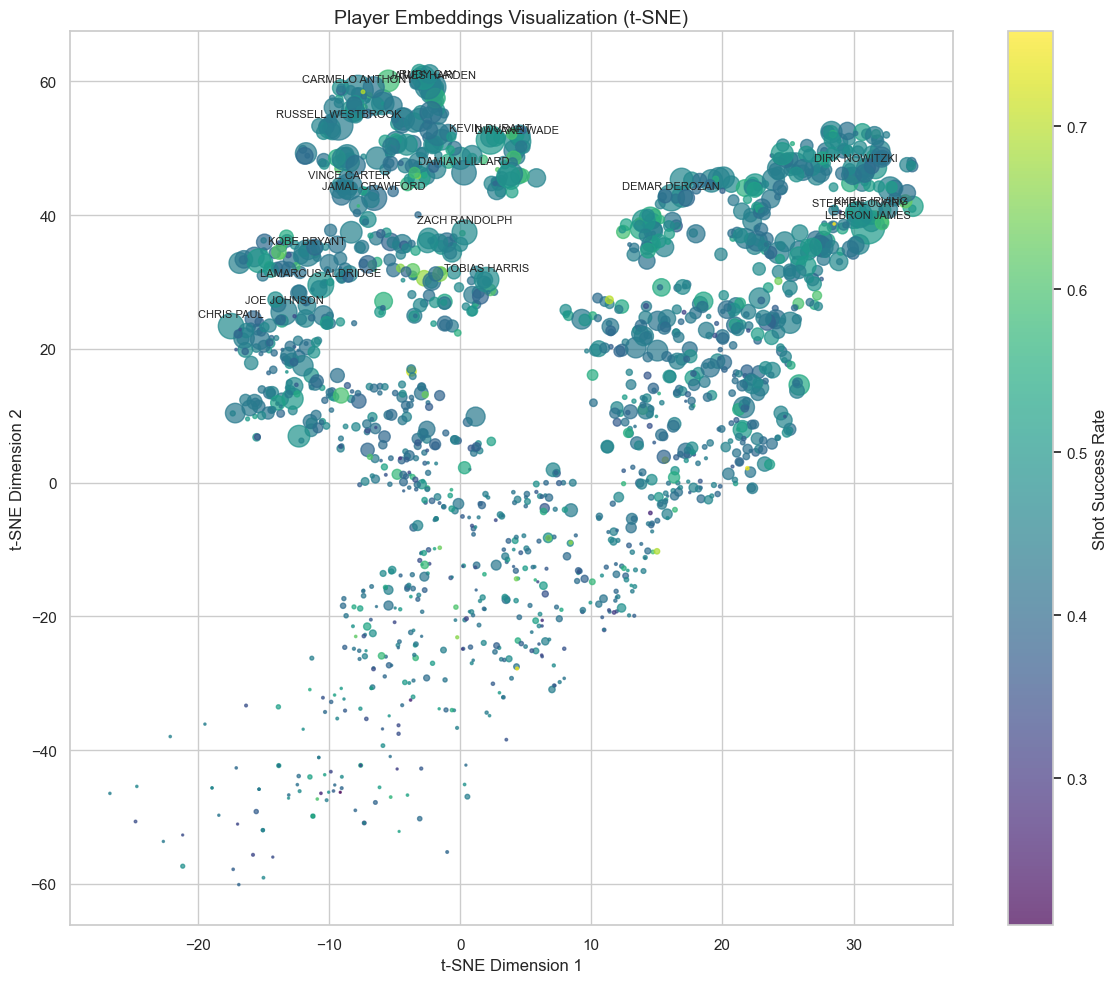

In [29]:
# Plot player embeddings
plt.figure(figsize=(12, 10))

# Filter to players with at least 100 shots for better visualization
min_shots = 100
viz_filtered = viz_df[viz_df['total_shots'] >= min_shots].copy()

# Create scatter plot
scatter = plt.scatter(
    viz_filtered['x'], 
    viz_filtered['y'],
    c=viz_filtered['success_rate'],
    s=viz_filtered['total_shots'] / 50,  # Size based on total shots
    cmap='viridis',
    alpha=0.7
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Shot Success Rate')

# Add labels for top players
top_n = 20
top_players = viz_filtered.sort_values('total_shots', ascending=False).head(top_n)
for _, player in top_players.iterrows():
    plt.annotate(
        player['player_name'],
        (player['x'], player['y']),
        fontsize=8,
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Player Embeddings Visualization (t-SNE)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

In [30]:
# Save model
model.save(player_embedding_dir / 'player_embedding_model.keras')
print(f"Model saved to {player_embedding_dir / 'player_embedding_model.keras'}")

Model saved to ../models/player_embedding/player_embedding_model.keras


## Key Insights

From our player embedding model, we've discovered several key insights:

1. **Player-specific patterns significantly impact shot success**, beyond what can be explained by spatial factors alone.

2. **Players cluster naturally in embedding space** based on similar shooting patterns, often corresponding to their playing styles and positions.

3. **The embedding model improves prediction accuracy** compared to the spatial-only model, demonstrating the importance of player identity in shot prediction.

4. **Player embeddings capture latent shooting characteristics** that aren't explicitly encoded in the features, such as shooting form, release speed, and decision-making tendencies.

5. **Similar players in embedding space** often share comparable playing styles, positions, or physical attributes, even though these weren't explicitly provided to the model.

These insights can help teams better understand player shooting tendencies, find player comparisons for scouting purposes, and improve defensive strategies against specific players. In the next notebook, we'll build a game context model to capture situational factors affecting shot success.